In [144]:
#%pip install --upgrade "fsspec>=2024.2.0" "s3fs>=2024.2.0" "xarray>=2024.1.0" "kerchunk>=0.2.6"

In [41]:
import fsspec
import logging, os
from dask.distributed import Client, progress
from kerchunk.hdf import SingleHdf5ToZarr
from kerchunk.combine import MultiZarrToZarr
import ujson, re, xarray as xr
for name in ["kerchunk","fsspec", "s3fs", "botocore", "aiobotocore", "s3fs.core","zarr","matplotlib"]:
    logging.getLogger(name).setLevel(logging.WARNING)

In [42]:
tas_ref = "/home/a1r/git/spear_refs/tas_ensemble_refs_local.json"

In [ ]:
if (not os.path.exists(tas_ref)):
   print("We need to create the reference")
else:
    print("Reference json exists")

In [33]:
#%pip install dask-gateway dask-gateway-server

In [ ]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:42025")
client

In [ ]:
from dask.distributed import Client
import dask

# Connect to your running cluster
# (if you started it via JupyterLab’s Dask panel, copy its address)
client = Client("tcp://127.0.0.1:42025")  # replace with your scheduler address
client

# Make this client the global default
dask.config.set(scheduler="distributed")

print(f"Dask dashboard: {client.dashboard_link}")

def check_dask():
    print("Scheduler:", dask.config.get("scheduler"))
    print("Client:", client)
    print("Workers:", len(client.scheduler_info()['workers']))
    print("Threads per worker:", [w['nthreads'] for w in client.scheduler_info()['workers'].values()])

check_dask()


In [43]:
#use data catalog to search for tas, group by ensemble member_id
import xarray as xr
import intake,yaml,os
import intake_esm
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
pd.set_option('display.max_rows', None)

In [44]:
col_url = "/home/a1r/git/spear-flp/catalog_blue.json"

In [45]:
col = intake.open_esm_datastore(col_url)

In [46]:
variable_id = "WVP"
expname_filter = ['SPEAR_c192_o1_Hist_AllForc_IC1921_K50']
realm = 'atmos'
frequency = "mon"
cat = col.search(experiment_id=expname_filter,variable_id=variable_id,frequency=frequency,
                 realm=realm)
#grouping = cat.df.groupby(['member_id'])

In [81]:
grouped = cat.df.groupby('member_id')['path'].apply(list).to_dict()

# concat over time for each ensemble member

In [153]:
import nest_asyncio
nest_asyncio.apply()

from kerchunk.hdf import SingleHdf5ToZarr
from kerchunk.combine import MultiZarrToZarr
import json

def build_member_ref(member_id, file_list):
    refs = []
    for path in file_list:
        #print(path)
        #h5chunks = SingleHdf5ToZarr(path, inline_threshold=300)  # just path
        fakeh5chunks = NetCDF3ToZarr(path) 

        refs.append(fakeh5chunks.translate())

    mzz = MultiZarrToZarr(refs, concat_dims=["time"], identical_dims=["lat", "lon"])
    member_ref = mzz.translate()
    ref_file = f"{member_id}_ref.json"
    with open(ref_file, "w") as f:
        json.dump(member_ref, f)
    return ref_file

In [154]:
#build one reference per member
member_refs = [build_member_ref(member, files) for member, files in grouped.items()]


Building 30-member ensemble reference...


In [158]:
import xarray as xr

datasets = []
member_ids = [f"pp_ens_{i:02d}" for i in range(1, 31)]

for rip in member_ids:
    ds = xr.open_dataset(
        "reference://",
        engine="zarr",
        backend_kwargs={"storage_options": {"fo": f"{rip}_ref.json"}},
        chunks={}
    )
    ds = ds.expand_dims(member_id=[rip])
    datasets.append(ds)


In [159]:
ds

<xarray.Dataset> Size: 912MB
Dimensions:     (member_id: 1, time: 1080, lat: 360, bnds: 2, lon: 576)
Coordinates:
  * member_id   (member_id) object 8B 'pp_ens_30'
  * time        (time) object 9kB 1921-01-16 12:00:00 ... 2010-12-16 12:00:00
  * lat         (lat) float64 3kB -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * lon         (lon) float64 5kB 0.3125 0.9375 1.562 ... 358.4 359.1 359.7
  * bnds        (bnds) float64 16B 1.0 2.0
Data variables:
    lat_bnds    (member_id, time, lat, bnds) float64 6MB dask.array<chunksize=(1, 1, 360, 2), meta=np.ndarray>
    lon_bnds    (member_id, time, lon, bnds) float64 10MB dask.array<chunksize=(1, 1, 576, 2), meta=np.ndarray>
    WVP         (member_id, time, lat, lon) float32 896MB dask.array<chunksize=(1, 1, 360, 576), meta=np.ndarray>
    average_DT  (member_id, time) timedelta64[ns] 9kB dask.array<chunksize=(1, 1), meta=np.ndarray>
    average_T1  (member_id, time) datetime64[ns] 9kB dask.array<chunksize=(1, 1), meta=np.ndarray>
    average_T2  (member_id, time) datetime64[ns] 9kB dask.array<chunksize=(1, 1), meta=np.ndarray>
    time_bnds   (member_id, time, bnds) timedelta64[ns] 17kB dask.array<chunksize=(1, 1, 2), meta=np.ndarray>
Attributes:
    title:         SPEAR_c192_o1_Hist_AllForc_IC1921_K50_ens_28_30
    grid_type:     regular
    grid_tile:     N/A
    comment:       pressure level interpolator, version 3.0, precision=double
    history:       fregrid --standard_dimension --input_mosaic C192_mosaic.nc...
    code_version:  $Name: bronx-10_performance_z1l $

In [160]:
# Concatenate into ensemble
ds_ens = xr.concat(datasets, dim="member_id")

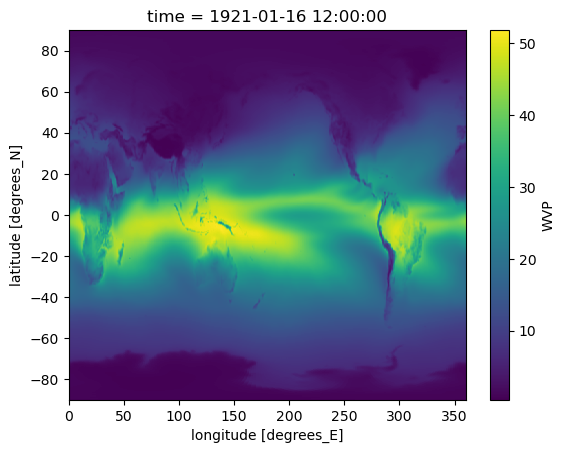

In [165]:
wvp = ds_ens["WVP"]
wvp_slice = wvp.isel(time=0)
wvp_mean = wvp_slice.mean(dim="member_id")
wvp_mean.plot()

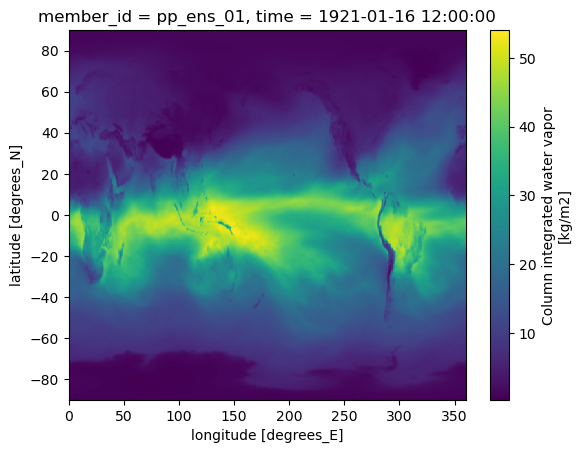

In [167]:
wvp_ens_slice = wvp.sel(member_id="pp_ens_01").isel(time=0)
wvp_ens_slice.plot()

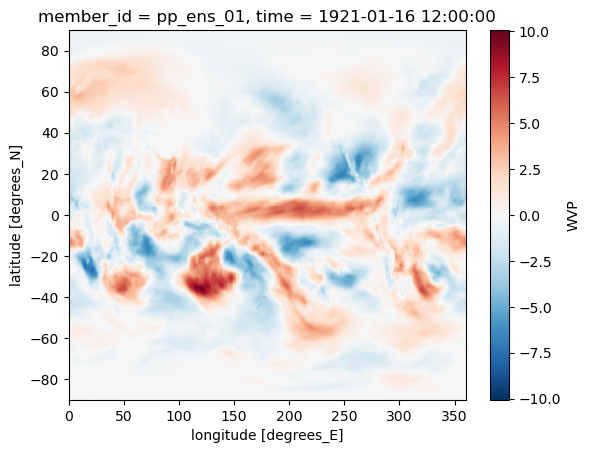

In [171]:
#ensemble deviation analysis
wvp_diff = wvp_ens_slice - wvp_mean 
wvp_diff.plot()

#SAD NETCDF-3
from kerchunk.hdf import SingleHdf5ToZarr
import json, scipy
from kerchunk.netCDF3 import NetCDF3ToZarr

path = "/data/2/GFDL-LARGE-ENSEMBLES/TFTEST/SPEAR_c192_o1_Hist_AllForc_IC1921_K50/pp_ens_01/atmos/ts/monthly/10yr/atmos.195101-196012.WVP.nc"

#ref = SingleHdf5ToZarr(path, inline_threshold=300).translate()
ref = NetCDF3ToZarr(path).translate()

json.dump(ref, open("test_ref.json", "w"))
print("Kerchunk worked.")


In [ ]:
import time
start_time = time.time()
#The long-term average temperature at each grid cell, averaged across all members — a climatological map of mean state.
#A spatial climatology map showing the long-term mean temperature pattern, 
#averaged across all ensemble members.
#Removes both the time variability and ensemble variability  
ens_time_mean = wvp.mean(dim=('member', 'time'))#.compute()
ens_time_mean.plot()


ValueError: 'member' not found in array dimensions ('member_id', 'time', 'lat', 'lon')

In [ ]:
end_time = time.time()
print(f"Total computation time: {end_time - start_time:.2f} seconds")